#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
file1 = 'data01_train.csv'
file2 = 'data01_test.csv'
file3 = 'features.csv'

In [ ]:
data = pd.read_csv(path + file1)
test = pd.read_csv(path + file2)
features = pd.read_csv(path + file3)

In [ ]:
# 불필요한 칼럼 삭제
data.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
data.shape

(5881, 562)

In [ ]:
#전체 데이터의 상위 5개 행 확인
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
#전체 데이터의 모든 변수 확인
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [ ]:
print(data['Activity'].unique())
data['is_dynamic'] = np.where(data['Activity'].isin(['STANDING', 'LAYING','SITTING']), 0, 1)

['STANDING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'
 'SITTING']


### (2) x, y 분리

In [ ]:
x = data.drop(['is_dynamic',  'Activity'], axis = 1)
y1 = data.loc[:, 'is_dynamic']
y2 = data.loc[:, 'Activity']

### (3) 데이터 분할
* train, val 분할

In [ ]:
x_train, x_val, y1_train, y1_val = train_test_split(x, y1, test_size = .2, random_state = 100)
_, _, y2_train, y2_val = train_test_split(x, y2, test_size = .2, random_state = 100)

### (4) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [ ]:
x_train  = x_train_scaled
x_val = x_val_scaled

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 모델1

In [ ]:
n_features = x_train.shape[1]
n_features

561

In [ ]:
# 모델 설계
do_rate = 0.1

model1_1 = Sequential([Dense(512, input_shape = [n_features, ], activation = 'relu'),
                     Dense(256, activation = 'relu'),
                     Dense(128, activation = 'relu'),
                     Dense(64, activation = 'relu'),
                     Dense(32, activation = 'relu'),
                     Dense(1, activation = 'sigmoid')])
model1_1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,337 (1.76 MB)

 Trainable params: 462,337 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y1_train.shape, x_train.shape

((4704,), (4704, 561))

In [ ]:
# 컴파일 및 학습
model1_1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
history = model1_1.fit(x_train, y1_train, epochs = 100, validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.1171 - val_loss: 6.4966e-04
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0075 - val_loss: 2.6819e-04
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 1.4443e-04
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3472e-04 - val_loss: 1.4818e-05
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1900e-05 - val_loss: 5.9346e-06
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7218e-06 - val_loss: 4.3698e-06
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.6087e-06 - val_loss: 3.0773e-06
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7899e-06 - val_loss: 2.2225e-06
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8014e-06 - val_loss: 1.5774e-06
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5803e-06 - val_loss: 9.3213e-07
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss

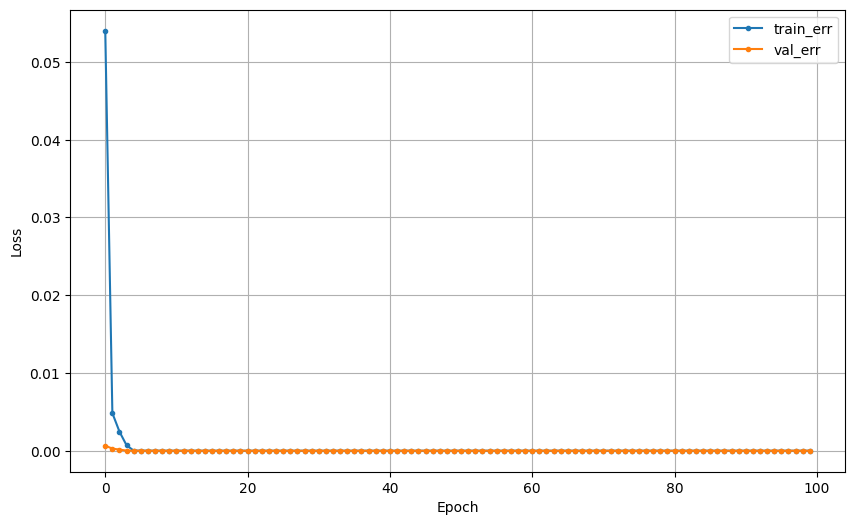

In [ ]:
dl_history_plot(history)

In [ ]:
pred1_1 = model1_1.predict(x_val)
pred1_1 = np.where(pred1_1 > .5, 1, 0)
print('accuracy :',accuracy_score(y1_val, pred1_1))
print('='*60)
print(confusion_matrix(y1_val, pred1_1))
print('='*60)
print(classification_report(y1_val, pred1_1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
accuracy : 0.9991503823279524
[[664   1]
 [  0 512]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       665
           1       1.00      1.00      1.00       512

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



#### 2) 모델2

In [ ]:
# 모델 설계
do_rate = 0.2

model1_2 = Sequential([Dense(512, input_shape = [n_features, ], activation = 'relu'),
                     Dropout(do_rate),
                     Dense(256, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(128, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(64, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(32, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(1, activation = 'sigmoid')])
model1_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,337 (1.76 MB)

 Trainable params: 462,337 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model1_2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
history = model1_2.fit(x_train, y1_train, epochs = 100, validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.1081 - val_loss: 0.0708
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0281 - val_loss: 6.1610e-06
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 8.2588e-07
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.3005e-05 - val_loss: 1.0097e-07
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1651e-04 - val_loss: 6.5176e-08
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7871e-05 - val_loss: 5.0059e-09
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3980e-05 - val_loss: 2.9599e-09
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3063e-06 - val_loss: 2.5420e-09
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0088 - val_loss: 0.0907
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss:

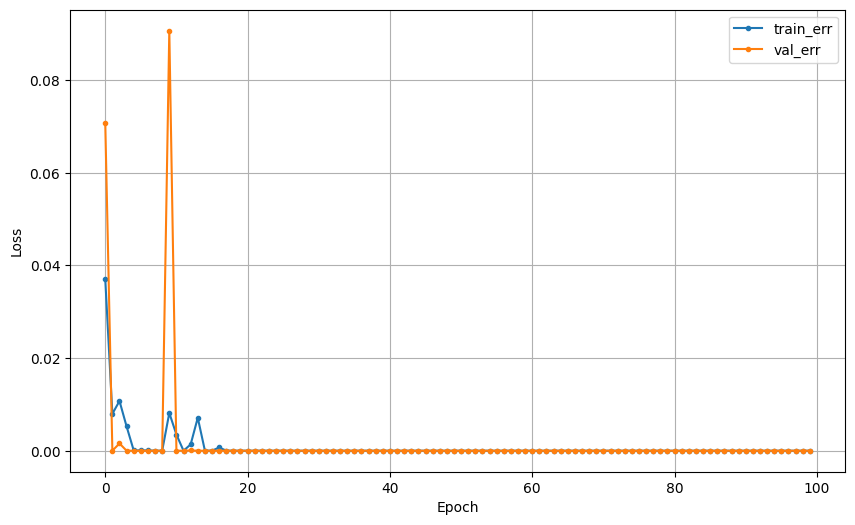

In [ ]:
dl_history_plot(history)

In [ ]:
pred1_2 = model1_2.predict(x_val)
pred1_2 = np.where(pred1_2 > .5, 1, 0)
print('accuracy :',accuracy_score(y1_val, pred1_2))
print('='*60)
print(confusion_matrix(y1_val, pred1_2))
print('='*60)
print(classification_report(y1_val, pred1_2))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
accuracy : 0.9991503823279524
[[664   1]
 [  0 512]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       665
           1       1.00      1.00      1.00       512

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
x_train_0 = x_train[y1_train == 0]
y2_train_0 = y2_train[y1_train == 0]

x_val_0 = x_val[y1_val == 0]
y2_val_0 = y2_val[y1_val == 0]

In [ ]:
int_encoder_0 = LabelEncoder()
y2_train_0 = y2_train_0.map({'LAYING':0, 'STANDING':1, 'SITTING':2})
y2_val_0 = y2_val_0.map({'LAYING':0, 'STANDING':1, 'SITTING':2})

In [ ]:
# 모델 설계
do_rate = 0.1

model2_1 = Sequential([Dense(512, input_shape = [n_features, ], activation = 'relu'),
                     Dropout(do_rate),
                     Dense(512, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(256, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(256, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(128, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(128, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(64, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(64, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(32, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(32, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(3, activation = 'softmax')])
model2_1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 512)            │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,579 (3.10 MB)

 Trainable params: 812,579 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model2_1.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')
history = model2_1.fit(x_train_0, y2_train_0, epochs = 100, validation_split=0.2).history

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - loss: 1.0977 - val_loss: 1.0696
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.0212 - val_loss: 0.5642
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5523 - val_loss: 0.5618
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5243 - val_loss: 0.4905
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5219 - val_loss: 0.4874
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5007 - val_loss: 0.4580
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4752 - val_loss: 0.4173
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4454 - val_loss: 0.3406
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3950 - val_loss: 0.2283
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3474 - val_loss: 0.2457
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2987 - val_loss: 0.1890
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 

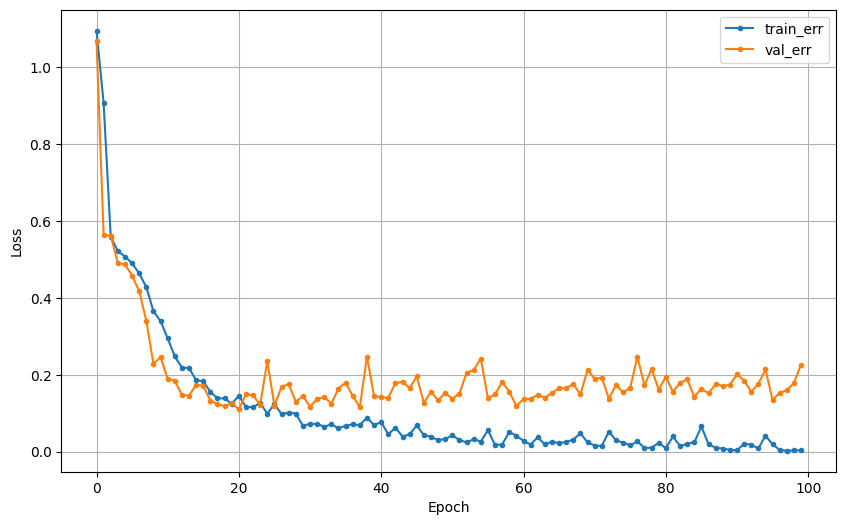

In [ ]:
# 학습곡선
dl_history_plot(history)

In [ ]:
# 예측 및 평가
pred2_1 = model2_1.predict(x_val_0)
pred2_1 = np.argmax(pred2_1, axis = 1)

print('accuracy :',accuracy_score(y2_val_0, pred2_1))
print('='*60)
print(confusion_matrix(y2_val_0, pred2_1))
print('='*60)
print(classification_report(y2_val_0, pred2_1, target_names = ['LAYING', 'SITTING', 'STANDING']))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
accuracy : 0.9729323308270676
[[227   0   0]
 [  0 208  11]
 [  0   7 212]]
              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00       227
     SITTING       0.97      0.95      0.96       219
    STANDING       0.95      0.97      0.96       219

    accuracy                           0.97       665
   macro avg       0.97      0.97      0.97       665
weighted avg       0.97      0.97      0.97       665



#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
x_train_1 = x_train[y1_train == 1]
y2_train_1 = y2_train[y1_train == 1]

x_val_1 = x_val[y1_val == 1]
y2_val_1 = y2_val[y1_val == 1]

In [ ]:
y2_train_1 = y2_train_1.map({'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2})
y2_val_1 = y2_val_1.map({'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2})

In [ ]:
# 모델 설계
do_rate = 0.1

model2_2 = Sequential([Dense(512, input_shape = [n_features, ], activation = 'relu'),
                     Dropout(do_rate),
                     Dense(512, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(256, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(256, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(128, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(128, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(64, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(64, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(32, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(32, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(3, activation = 'softmax')])
model2_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 512)            │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,579 (3.10 MB)

 Trainable params: 812,579 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model2_2.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')
history = model2_2.fit(x_train_1, y2_train_1, epochs = 100, validation_split=0.2).history

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - loss: 1.0937 - val_loss: 1.0278
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.0365 - val_loss: 0.7351
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7926 - val_loss: 0.5059
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6217 - val_loss: 0.3845
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4617 - val_loss: 0.2037
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3164 - val_loss: 0.1692
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2768 - val_loss: 0.0892
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2028 - val_loss: 0.0678
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1508 - val_loss: 0.0982
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1409 - val_loss: 0.1099
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1169 - val_loss: 0.0514
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 

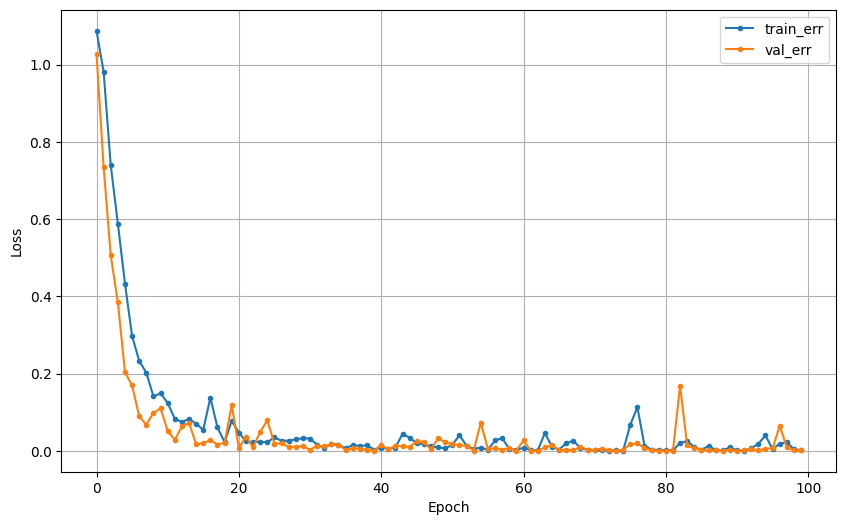

In [ ]:
# 학습곡선
dl_history_plot(history)

In [ ]:
# 예측 및 평가
pred2_2 = model2_2.predict(x_val_1)
pred2_2 = np.argmax(pred2_2, axis = 1)

print('accuracy :',accuracy_score(y2_val_1, pred2_2))
print('='*60)
print(confusion_matrix(y2_val_1, pred2_2))
print('='*60)
print(classification_report(y2_val_1, pred2_2, target_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
accuracy : 0.994140625
[[196   1   1]
 [  0 175   0]
 [  0   1 138]]
                    precision    recall  f1-score   support

           WALKING       1.00      0.99      0.99       198
  WALKING_UPSTAIRS       0.99      1.00      0.99       175
WALKING_DOWNSTAIRS       0.99      0.99      0.99       139

          accuracy                           0.99       512
         macro avg       0.99      0.99      0.99       512
      weighted avg       0.99      0.99      0.99       512



### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
def model_comb(model1, model2_1, model2_2, new_data, scaler):

    # 1. 전처리 -----------------------------------

    ## 1) 스케일링
    col_name = list(new_data)[:-1]
    new_data.loc[:,col_name] = scaler.transform(new_data.loc[:,col_name])

    ## 2) 입력값 만들기
    new_x = new_data.drop(['Activity'], axis = 1)


    # 2.예측 -----------------------------------

    ## 1) 단계1 모델로 0,1 구분
    pred1 = model1_1.predict(new_x)
    pred1 = np.where(pred1 > .5, 1, 0)

    new_data['pred1'] = pred1


    ## 2) 단계1의 결과로 데이터 나누기
    new_x_0 = new_data.loc[new_data['pred1'] == 0]
    new_x_1 = new_data.loc[new_data['pred1'] == 1]
    x_0 = new_x_0.drop(['Activity','pred1'], axis = 1)
    x_1 = new_x_1.drop(['Activity','pred1'], axis = 1)

    ## 3) 단계2 모델로 예측.
    pred2_1 = model2_1.predict(x_0)
    pred2_1 = pred2_1.argmax(axis = 1)
    pred2_2 = model2_2.predict(x_1)
    pred2_2 = pred2_2.argmax(axis = 1)

    ## 4) 예측 결과를 원래 값으로 변환
    new_x_0['pred2'] = pred2_1
    new_x_0['pred2'] = new_x_0['pred2'].map({0:'LAYING', 1:'STANDING', 2:'SITTING'})

    new_x_1['pred2'] = pred2_2
    new_x_1['pred2'] = new_x_1['pred2'].map({0:'WALKING', 1:'WALKING_UPSTAIRS', 2:'WALKING_DOWNSTAIRS'})

    ## 5) 하나로 합치기
    result = pd.concat([new_x_0, new_x_1], axis = 0)

    # 3.최종 성능평가 -----------------------------------
    print('accuracy :',accuracy_score(result['pred2'], result['Activity']))
    print('='*60)
    print(confusion_matrix(result['pred2'], result['Activity']))
    print('='*60)
    print(classification_report(result['pred2'], result['Activity']))

#### 2) test 셋으로 예측하고 평가하기

In [ ]:
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


* 성능 평가

In [ ]:
model_comb(model1_1, model2_1, model2_2, test, scaler)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
accuracy : 0.9857239972807614
[[292   0   0   0   0   0]
 [  0 248  13   0   0   0]
 [  0   6 274   0   0   0]
 [  0   0   0 227   0   1]
 [  0   0   0   0 195   0]
 [  0   0   0   1   0 214]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.98      0.95      0.96       261
          STANDING       0.95      0.98      0.97       280
           WALKING       1.00      1.00      1.00       228
WALKING_DOWNSTAIRS       1.00      1.00      1.00       195
  WALKING_UPSTAIRS       1.00      1.00      1.00       215

          accuracy                           0.99      1471
         macro avg       0.99      0.99      0.99      1471
      weighted avg       0.99      0.99      0.99      1471



<ipython-input-39-0e53bac377fe>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_x_0['pred2'] = pred2_1
<ipython-input-39-0e53bac377fe>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_x_0['pred2'] = new_x_0['pred2'].map({0:'LAYING', 1:'STANDING', 2:'SITTING'})
<ipython-input-39-0e53bac377fe>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py